<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/MARCA-Color.jpg" title="Title text" width="50%" height="50%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales II-2018 </h1>

<H3 align='center'> Tarea 3 - Redes Recurrentes y Autoencoders </H3>
<hr style="height:2px;border:none"/>



**Temas**  
* Diseño e implementación de Redes Neuronales Recurrentes (RNN).
* Regularización en Redes Recurrentes.
* Autoencoders tradicionales y sus aplicaciones

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 21 de Diciembre (sin posibilidad de extensiones)
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<margarita.bugueno.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<cvalle@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF395-II-2018] 

<hr style="height:2px;border:none"/>

La tarea se divide en dos secciones:

[1.](#primero) RNN sobre texto    
[2.](#segundo) Autoencoder en MNIST  


### **Nota Importante:**  
Para esta actividad **si es que no se cuenta con GPU** se recomienda utilizar el entorno virtual de __[Colaboratory - Google](https://colab.research.google.com/)__* . Así, podrá programar en la nube con recursos elevados y luego descargar el Jupyter Notebook y entregarlo en modo Informe. 


Primeramente se importan las librerías mas relevantes para este trabajo.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import seaborn as sns
import matplotlib.cm as cm
import os   
import keras as krs
import math
import h5py
import pickle
import getpass

from keras import utils as np_utils
from keras import backend as bknd

from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Activation, Input, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.datasets import cifar10, mnist
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, rmsprop
from keras.layers.core import Dense, Activation
from keras.regularizers import l1,l2
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


Se define un directorio dentro de Drive para guardar los resultados de los entrenamientos.

Se utilizará para esto drive y pickle.

In [4]:
from google.colab import drive
import pickle

drive.mount('/content/drive', force_remount=True)
DATA_PATH = "/content/drive/My Drive/Colab Tarea 3/Models/"

# pickle.dump(variable, open(DATA_PATH+'file.p','wb'))
# infile = open(DATA_PATH+'/file.p','rb')
# historias = pickle.load(infile)

Mounted at /content/drive


In [0]:
def Repartir_Conjuntos(Train,Test,x,y):
  print("This function splits the framework this way:\n Train from 0% to (First parameter)%\n Test from (First parameter)% to (First+Second parameter)%\n Validation will be the rest.")
  if (0<Train<1) == False:
    print("ERROR: First parameter must be type float between 0 and 1")
    return
  if (0<Test<1) == False:
    print("ERROR: Second parameter must be type float between 0 and 1")
    return
  if (Train+Test<1) == False:
    print("ERROR: First parameter plus Second parameter can't be bigger than one")
    return
  
  largo = len(x);
  Train=int(Train*largo);
  Test = int(Test*largo + Train);
  (x_train, y_train)=x[0:Train],y[0:Train];
  (x_test, y_test)=x[Train:Test],y[Train:Test];
  (x_val, y_val)=x[Test:],y[Test:];
  return((x_train, y_train),(x_test, y_test),(x_val, y_val))
  

<a id="segundo"></a>
## 2. Autoencoders (AEs) en MNIST


Como se ha discutido en clases, las RBM’s y posteriormente los AE’s (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. En esta sección aprenderemos a utilizar el más sencillo de estos modelos: un autoencoder o AE. Consideraremos tres aplicaciones clásicas: reducción de dimensionalidad, *denoising* y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado MNIST[[3]](#refs). Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes. La tarea consiste en construir un programa para que aprenda a identificar correctamente el dı́gito representado en la imagen


> a) Escriba el código que **cargue los datos** desde el repositorio de keras, normalice las imágenes de modo que los pixeles queden en [0, 1], transforme las imágenes en vectores ($\in {\rm I\!R}^{784}$) y devuelva tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. Construya el conjunto de validación de la manera que estime conveniente, éste debe contar con $nval = 5000$ imágenes.

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.concatenate((x_train,x_test), axis=0);
x = x.astype('float32') / 255.
y = np.concatenate((y_train,y_test), axis=0);
[[x_train, y_train],[x_test, y_test],[x_val, y_val]]=Repartir_Conjuntos(0.6632653,0.26530612,x,y)  # resta el 7.1428571% ~ 5000 imagenes

print("-----------------------------------")
print("x_train's shape: ",x_train.shape)
print("y_train's shape: ",y_train.shape)
print("x_test's shape:  ",x_test.shape)
print("y_test's shape:  ",y_test.shape)
print("x_val's shape:   ",x_val.shape)
print("y_vals's shape:  ",y_val.shape)

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

print("-----------------------------------")
print("x_train's shape: ",x_train.shape)
print("y_train's shape: ",y_train.shape)
print("x_test's shape:  ",x_test.shape)
print("y_test's shape:  ",y_test.shape)
print("x_val's shape:   ",x_val.shape)
print("y_val's shape:   ",y_val.shape)

This function splits the framework this way:
 Train from 0% to (First parameter)%
 Test from (First parameter)% to (First+Second parameter)%
 Validation will be the rest.
-----------------------------------
x_train's shape:  (46428, 28, 28)
y_train's shape:  (46428,)
x_test's shape:   (18571, 28, 28)
y_test's shape:   (18571,)
x_val's shape:    (5001, 28, 28)
y_vals's shape:   (5001,)
-----------------------------------
x_train's shape:  (46428, 784)
y_train's shape:  (46428,)
x_test's shape:   (18571, 784)
y_test's shape:   (18571,)
x_val's shape:    (5001, 784)
y_val's shape:    (5001,)


### 2.1 Reducción de dimensionalidad
Para esta primera sección, gracias a la simplicidad del problema tratado, se experimentará con un autoencoder tradicional (*feed forward*) en donde las capas de éste sean densas. Para esto se re estructurarán los datos de entradas en forma de vector, es decir la matriz de 28 $\times$ 28 pasa a ser un vector de 784 componentes.


Una de las aplicaciones tı́picas de un AE es reducción de dimensionalidad, es decir, implementar una transformación $\phi:{\rm I\!R}^d \rightarrow {\rm I\!R}^{d'}$ de objetos representados originalmente por $d$ atributos en una nueva representación de $d'$ atributos, de modo tal que se preserve lo mejor posible la “información” original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadı́stico (permite construir modelos con un menor número de parámetros libres). Un AE es una técnica de reducción de dimensionalidad no supervisada porque no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento.  

> a) Entrene un AE básico (1 capa escondida) para generar una representación de MNIST en $d'$= 2, 8, 32, 64 dimensiones. **Justifique la elección de la función de pérdida a utilizar y del criterio de entrenamiento en general**. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. **¿Mejora el resultado si elegimos una función de activación *ReLU* para el *Encoder*? ¿Podrı́a y/o corresponde utilizar ésta activación en el *Decoder*?**

In [0]:
D = [2,4,8,16,32,64]
n_epocs=40

historias = {}

for d in D:
  input_img = Input(shape=(784,))

  encoded = Dense(d, activation='sigmoid')(input_img)
  decoded = Dense(784, activation='sigmoid')(encoded)

  autoencoder = Model(input=input_img, output=decoded)

  encoder = Model(input=input_img, output=encoded)
  encoded_input = Input(shape=(d,))
  decoder_layer = autoencoder.layers[-1]
  decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
  
  autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
  historias['T3_P2_1_sigmoide_bc_d'+str(d)] = autoencoder.fit(x_train,x_train,epochs=n_epocs,batch_size=32,validation_data=(x_val,x_val))
  
  autoencoder.save(DATA_PATH+'T3_P2_1_sigmoide_bc_d'+str(d)+'.h5')
  
  ############################################################################################  
  input_img = Input(shape=(784,))

  encoded = Dense(d, activation='sigmoid')(input_img)
  decoded = Dense(784, activation='sigmoid')(encoded)

  autoencoder = Model(input=input_img, output=decoded)

  encoder = Model(input=input_img, output=encoded)
  encoded_input = Input(shape=(d,))
  decoder_layer = autoencoder.layers[-1]
  decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
  
  autoencoder.compile(optimizer=SGD(lr=1.0), loss='mean_squared_error')
  historias['T3_P2_1_sigmoide_mse_d'+str(d)] = autoencoder.fit(x_train,x_train,epochs=n_epocs,batch_size=32,validation_data=(x_val,x_val))
  
  autoencoder.save(DATA_PATH+'T3_P2_1_sigmoide_mse_d'+str(d)+'.h5')
  
  ############################################################################################
  encoded = Dense(d, activation='relu')(input_img)
  decoded = Dense(784, activation='sigmoid')(encoded)

  autoencoder = Model(input=input_img, output=decoded)

  encoder = Model(input=input_img, output=encoded)
  encoded_input = Input(shape=(d,))
  decoder_layer = autoencoder.layers[-1]
  decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
  
  autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
  historias['T3_P2_1_relu_bc_d'+str(d)] = autoencoder.fit(x_train,x_train,epochs=n_epocs,batch_size=32,validation_data=(x_val,x_val))
  
  autoencoder.save(DATA_PATH+'T3_P2_1_relu_bc_d'+str(d)+'.h5')
  
  ############################################################################################
  encoded = Dense(d, activation='relu')(input_img)
  decoded = Dense(784, activation='sigmoid')(encoded)

  autoencoder = Model(input=input_img, output=decoded)

  encoder = Model(input=input_img, output=encoded)
  encoded_input = Input(shape=(d,))
  decoder_layer = autoencoder.layers[-1]
  decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
  
  autoencoder.compile(optimizer=SGD(lr=1.0), loss='mean_squared_error')
  historias['T3_P2_1_relu_mse_d'+str(d)] = autoencoder.fit(x_train,x_train,epochs=n_epocs,batch_size=32,validation_data=(x_val,x_val))
  
  autoencoder.save(DATA_PATH+'T3_P2_1_relu_mse_d'+str(d)+'.h5')

pickle.dump(historias,open(DATA_PATH+'historias_def.p','wb'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


Train on 46428 samples, validate on 5001 samples
Epoch 1/40
46428/46428 [==============================] - 7s 149us/step - loss: 0.4738 - val_loss: 0.3684
Epoch 2/40
46428/46428 [==============================] - 6s 133us/step - loss: 0.3312 - val_loss: 0.3166
Epoch 3/40
46428/46428 [==============================] - 6s 134us/step - loss: 0.3000 - val_loss: 0.2992
Epoch 4/40
46428/46428 [==============================] - 6s 134us/step - loss: 0.2875 - val_loss: 0.2908
Epoch 5/40
46428/46428 [==============================] - 6s 134us/step - loss: 0.2811 - val_loss: 0.2860
Epoch 6/40
46428/46428 [==============================] - 6s 134us/step - loss: 0.2771 - val_loss: 0.2829
Epoch 7/40
46428/46428 [==============================] - 6s 134us/step - loss: 0.2745 - val_loss: 0.2807
Epoch 8/40
46428/46428 [==============================] - 6s 134us/step - loss: 0.2727 - val_loss: 0.2792
Epoch 9/40
46428/46428 [==============================] - 6s 134us/step - loss: 0.2713 - val_loss: 0.27

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 46428 samples, validate on 5001 samples
Epoch 1/40
46428/46428 [==============================] - 6s 122us/step - loss: 0.1626 - val_loss: 0.1200
Epoch 2/40
46428/46428 [==============================] - 5s 110us/step - loss: 0.1022 - val_loss: 0.0935
Epoch 3/40
46428/46428 [==============================] - 5s 110us/step - loss: 0.0859 - val_loss: 0.0844
Epoch 4/40
46428/46428 [==============================] - 5s 110us/step - loss: 0.0793 - val_loss: 0.0801
Epoch 5/40
46428/46428 [==============================] - 5s 111us/step - loss: 0.0759 - val_loss: 0.0778
Epoch 6/40
46428/46428 [==============================] - 5s 111us/step - loss: 0.0740 - val_loss: 0.0763
Epoch 7/40
46428/46428 [==============================] - 5s 111us/step - loss: 0.0727 - val_loss: 0.0753
Epoch 8/40
46428/46428 [==============================] - 5s 109us/step - loss: 0.0718 - val_loss: 0.0746
Epoch 9/40
46428/46428 [==============================] - 5s 111us/step - loss: 0.0711 - val_loss: 0.07

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 46428 samples, validate on 5001 samples
Epoch 1/40
46428/46428 [==============================] - 7s 149us/step - loss: 0.2794 - val_loss: 0.2571
Epoch 2/40
46428/46428 [==============================] - 6s 135us/step - loss: 0.2510 - val_loss: 0.2539
Epoch 3/40
46428/46428 [==============================] - 6s 135us/step - loss: 0.2477 - val_loss: 0.2509
Epoch 4/40
46428/46428 [==============================] - 6s 136us/step - loss: 0.2448 - val_loss: 0.2481
Epoch 5/40
46428/46428 [==============================] - 6s 137us/step - loss: 0.2427 - val_loss: 0.2469
Epoch 6/40
46428/46428 [==============================] - 6s 135us/step - loss: 0.2414 - val_loss: 0.2456
Epoch 7/40
46428/46428 [==============================] - 6s 134us/step - loss: 0.2406 - val_loss: 0.2453
Epoch 8/40
46428/46428 [==============================] - 6s 134us/step - loss: 0.2401 - val_loss: 0.2449
Epoch 9/40
46428/46428 [==============================] - 6s 134us/step - loss: 0.2397 - val_loss: 0.24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 46428 samples, validate on 5001 samples
Epoch 1/40
46428/46428 [==============================] - 6s 122us/step - loss: 0.0822 - val_loss: 0.0720
Epoch 2/40
46428/46428 [==============================] - 5s 109us/step - loss: 0.0667 - val_loss: 0.0659
Epoch 3/40
46428/46428 [==============================] - 5s 109us/step - loss: 0.0633 - val_loss: 0.0645
Epoch 4/40
46428/46428 [==============================] - 5s 108us/step - loss: 0.0627 - val_loss: 0.0641
Epoch 5/40
46428/46428 [==============================] - 5s 108us/step - loss: 0.0623 - val_loss: 0.0638
Epoch 6/40
46428/46428 [==============================] - 5s 107us/step - loss: 0.0620 - val_loss: 0.0635
Epoch 7/40
46428/46428 [==============================] - 5s 107us/step - loss: 0.0617 - val_loss: 0.0632
Epoch 8/40
46428/46428 [==============================] - 5s 110us/step - loss: 0.0613 - val_loss: 0.0628
Epoch 9/40
46428/46428 [==============================] - 5s 110us/step - loss: 0.0610 - val_loss: 0.06

In [0]:
infile = open(DATA_PATH+'historias_def.p','rb')
historias = pickle.load(infile)
print(historias.keys())

dict_keys(['T3_P2_1_sigmoide_bc_d2', 'T3_P2_1_sigmoide_mse_d2', 'T3_P2_1_relu_bc_d2', 'T3_P2_1_relu_mse_d2', 'T3_P2_1_sigmoide_bc_d4', 'T3_P2_1_sigmoide_mse_d4', 'T3_P2_1_relu_bc_d4', 'T3_P2_1_relu_mse_d4', 'T3_P2_1_sigmoide_bc_d8', 'T3_P2_1_sigmoide_mse_d8', 'T3_P2_1_relu_bc_d8', 'T3_P2_1_relu_mse_d8', 'T3_P2_1_sigmoide_bc_d16', 'T3_P2_1_sigmoide_mse_d16', 'T3_P2_1_relu_bc_d16', 'T3_P2_1_relu_mse_d16', 'T3_P2_1_sigmoide_bc_d32', 'T3_P2_1_sigmoide_mse_d32', 'T3_P2_1_relu_bc_d32', 'T3_P2_1_relu_mse_d32', 'T3_P2_1_sigmoide_bc_d64', 'T3_P2_1_sigmoide_mse_d64', 'T3_P2_1_relu_bc_d64', 'T3_P2_1_relu_mse_d64'])


In [0]:
modelos = ['T3_P2_1_relu_bc_d2','T3_P2_1_relu_bc_d4','T3_P2_1_relu_bc_d8','T3_P2_1_relu_bc_d16','T3_P2_1_relu_bc_d32','T3_P2_1_relu_bc_d64',
           'T3_P2_1_relu_mse_d2','T3_P2_1_relu_mse_d4','T3_P2_1_relu_mse_d8','T3_P2_1_relu_mse_d16','T3_P2_1_relu_mse_d32','T3_P2_1_relu_mse_d64',
           'T3_P2_1_sigmoide_bc_d2','T3_P2_1_sigmoide_bc_d4','T3_P2_1_sigmoide_bc_d8','T3_P2_1_sigmoide_bc_d16','T3_P2_1_sigmoide_bc_d32','T3_P2_1_sigmoide_bc_d64',
           'T3_P2_1_sigmoide_mse_d2','T3_P2_1_sigmoide_mse_d4','T3_P2_1_sigmoide_mse_d8','T3_P2_1_sigmoide_mse_d16','T3_P2_1_sigmoide_mse_d32','T3_P2_1_sigmoide_mse_d64'
          ]

for i in modelos:
  print(i)
  mod = load_model(DATA_PATH+i+'.h5')
  mod.summary()

T3_P2_1_relu_bc_d2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1570      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________
T3_P2_1_relu_bc_d4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 3140      
____________________________________

Se realiza el entrenamiento de las capas y se imprime la estructura de cada una de estas con fines de verificación de resultados. Se puede ver que las estructuras son como se esperaba.

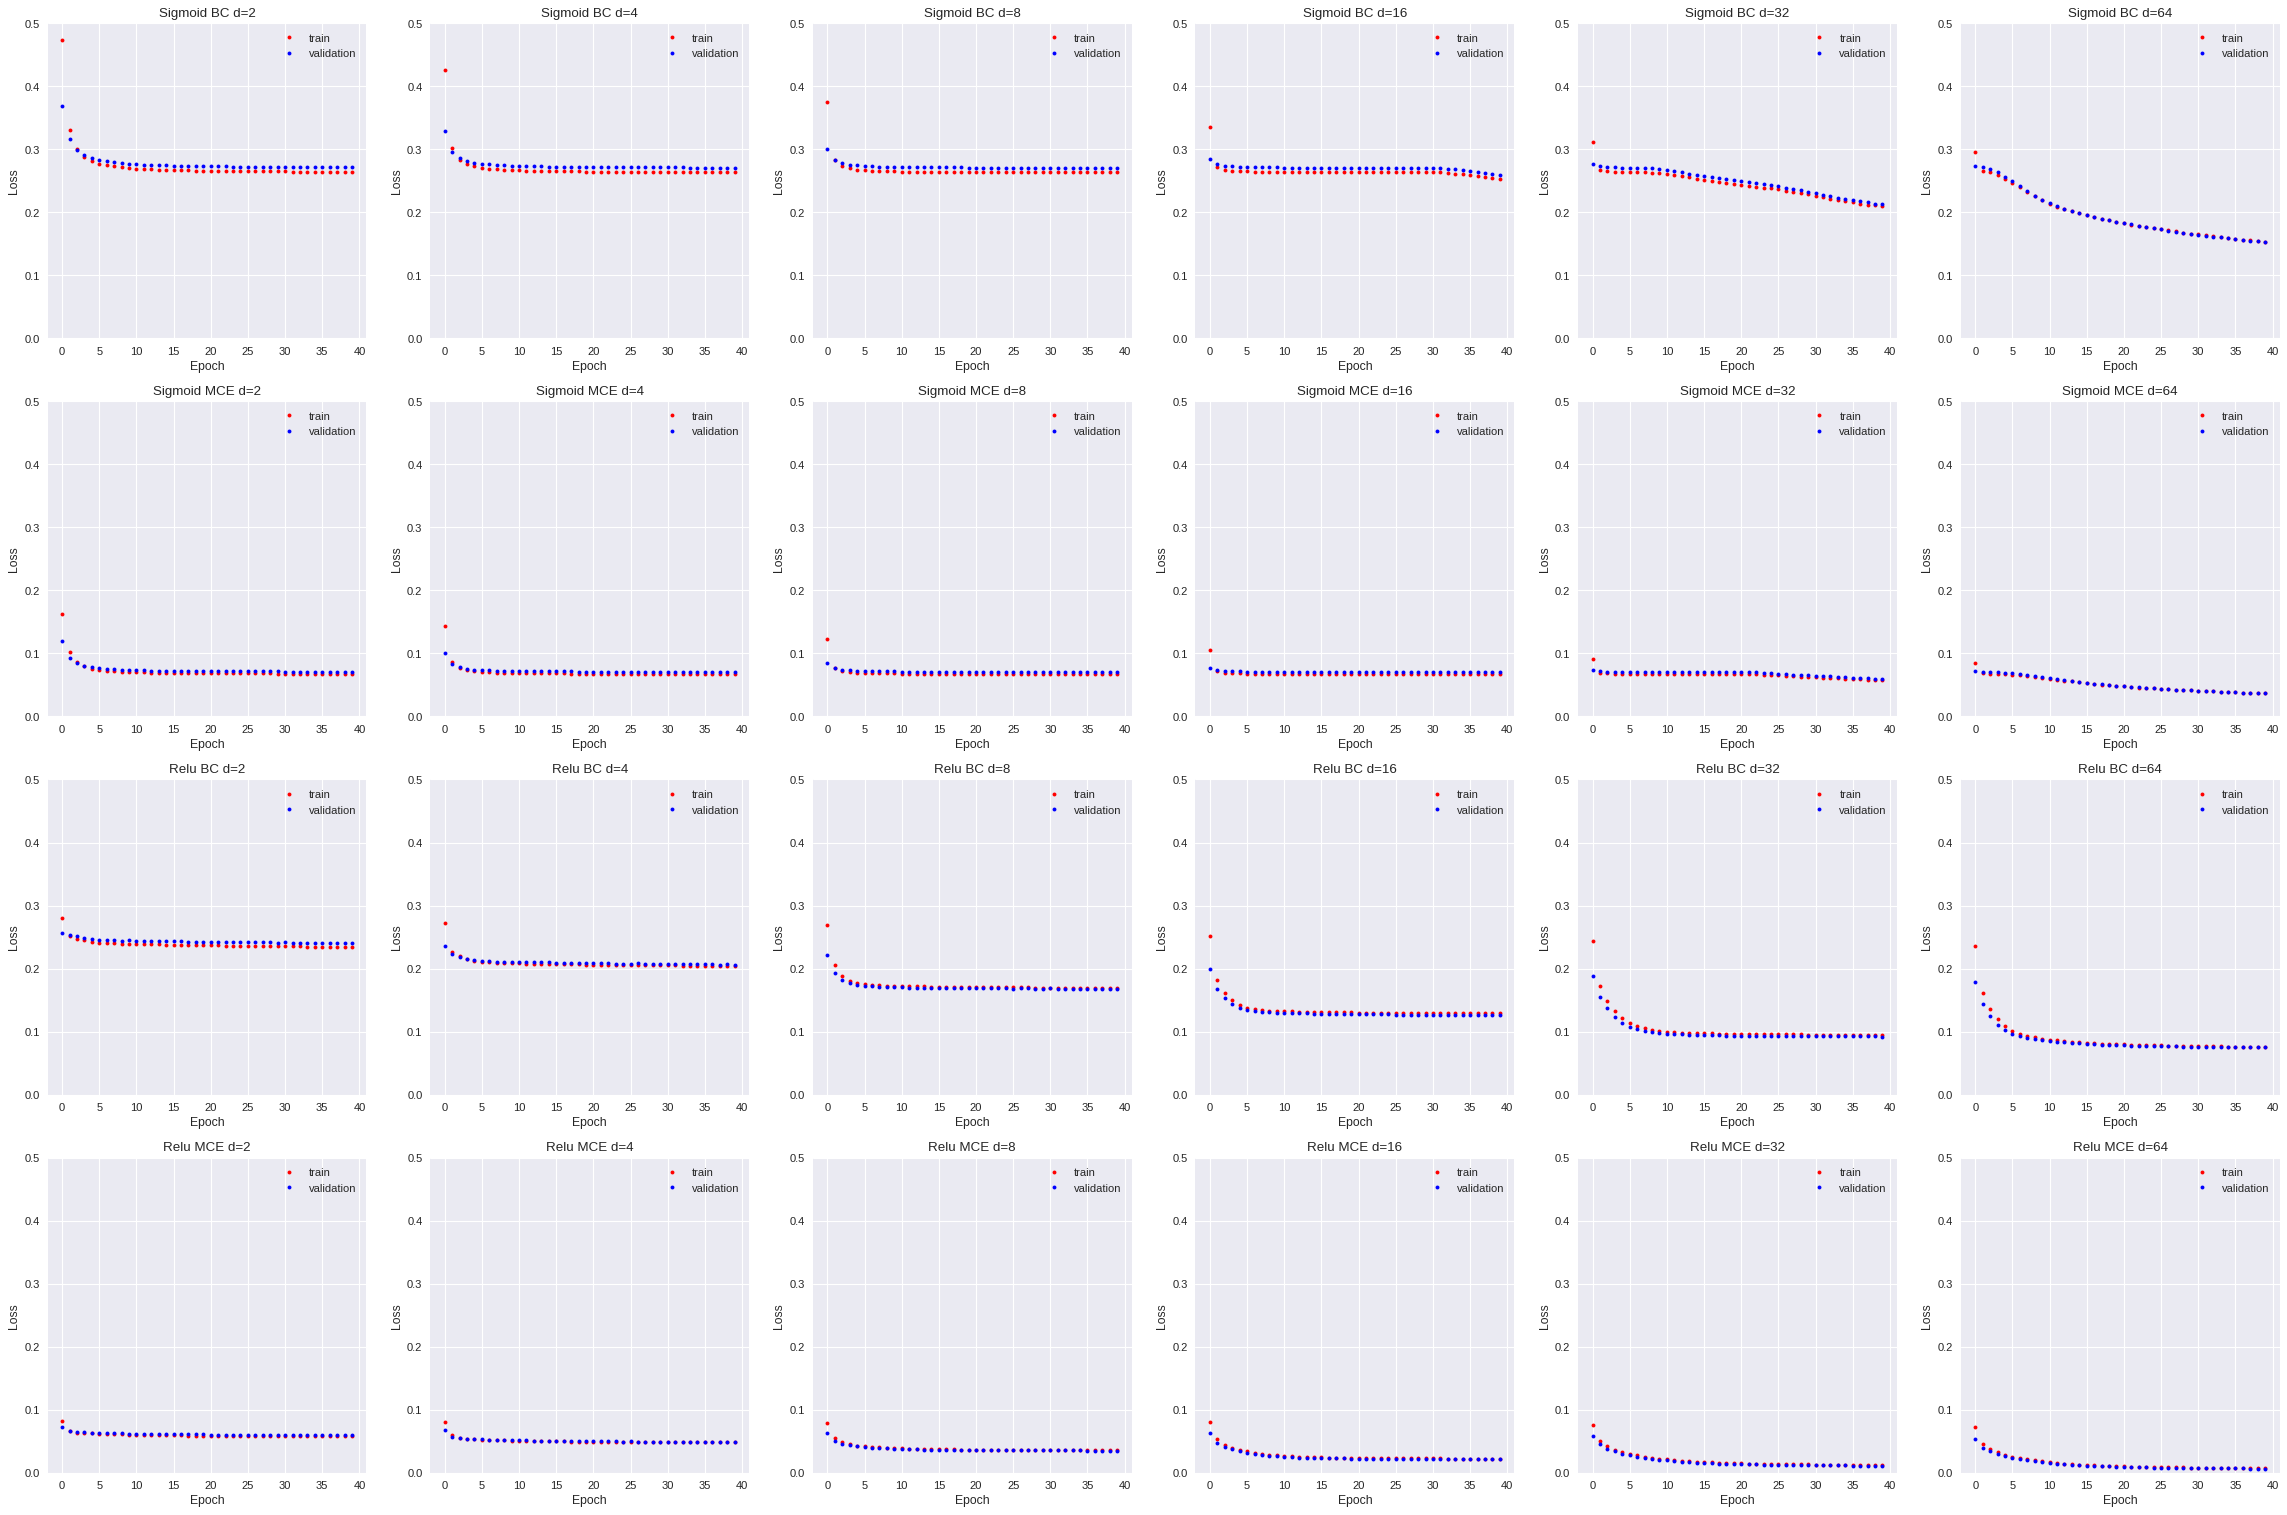

In [0]:
a = 0
b = 0.5

D = [2,4,8,16,32,64]

figuras = 4*len(D)
filas = 4

plt.figure(None, figsize=(6*figuras/filas, 6*filas), dpi=80, facecolor='w', edgecolor='k')

for i in range(int(figuras/filas)):
  plt.subplot(filas,figuras/filas,i+1)
  autoencoder =  historias['T3_P2_1_sigmoide_bc_d'+str(D[i])]
  plt.plot(autoencoder.history['loss'],'.r',label='train');
  plt.plot(autoencoder.history['val_loss'],'.b',label='validation');
  plt.ylabel('Loss');
  plt.xlabel('Epoch');
  plt.title('Sigmoid BC d='+str(D[i]));
  plt.ylim([a,b])
  plt.legend();

  plt.subplot(filas,figuras/filas,figuras/filas+i+1)
  autoencoder = historias['T3_P2_1_sigmoide_mse_d'+str(D[i])]
  plt.plot(autoencoder.history['loss'],'.r',label='train');
  plt.plot(autoencoder.history['val_loss'],'.b',label='validation');
  plt.ylabel('Loss');
  plt.xlabel('Epoch');
  plt.title('Sigmoid MCE d='+str(D[i]));
  plt.ylim([a,b])
  plt.legend();
  
  plt.subplot(filas,figuras/filas,2*figuras/filas+i+1)
  autoencoder = historias['T3_P2_1_relu_bc_d'+str(D[i])]
  plt.plot(autoencoder.history['loss'],'.r',label='train');
  plt.plot(autoencoder.history['val_loss'],'.b',label='validation');
  plt.ylabel('Loss');
  plt.xlabel('Epoch');
  plt.title('Relu BC d='+str(D[i]));
  plt.ylim([a,b])
  plt.legend();

  plt.subplot(filas,figuras/filas,3*figuras/filas+i+1)
  autoencoder =  historias['T3_P2_1_relu_mse_d'+str(D[i])]
  plt.plot(autoencoder.history['loss'],'.r',label='train');
  plt.plot(autoencoder.history['val_loss'],'.b',label='validation');
  plt.ylabel('Loss');
  plt.xlabel('Epoch');
  plt.title('Relu MCE d='+str(D[i]));
  plt.ylim([a,b])
  plt.legend();


Se procesde ahora a graficar las pérdidas de cada red simulada. Puede verse variaciones en la velocidad de convergencia, el nivel del error en estado estacionario y el comportamiento general del decaimiento. Se observa además que hay estructuras que no alcanzan a llegar a estado estacionario en 40 epochs. No se analizará el problema para mas epochs por temas de costo temporal y computacional.

Se puede apreciar que el error disminuye entre mas neuronas tiene la capa de codificada. Se ve en los primeros casos que se llega a un estado estacionario aparentemente estático, pero debido al resultado del gráfico de la esquina superior derecha (act=sigmoid, loss =binary crossentropy, neurons = 64) no se cierra la posibilidad de que otras redes pudiesen seguir disminuyendo su error. 

Se comprueba que al utilizar Relu el resultado mejora enormemente. En el caso de d=64, se aprecia una tendencia a la mejora del rendimiento para el caso de activación sigmoidal, pero el error utilizando Relu es practicamente cero en este caso. Se nota además que el metodo de Mean Squared Error funciona mucho mejor que Binary Cressentropy. 

#####FALTA: RELU A LA SALIDA?


> b) Compare visualmente la reconstrucción que logra hacer el *autoencoder* desde la representación en ${\rm I\!R}^{d'}$ para algunas imágenes del conjunto de pruebas. **Determine si la percepción visual se corresponde con el error de reconstrucción observada**. Comente.

Activation: Sigmoid
Loss: Binary Crossentropy
d=2


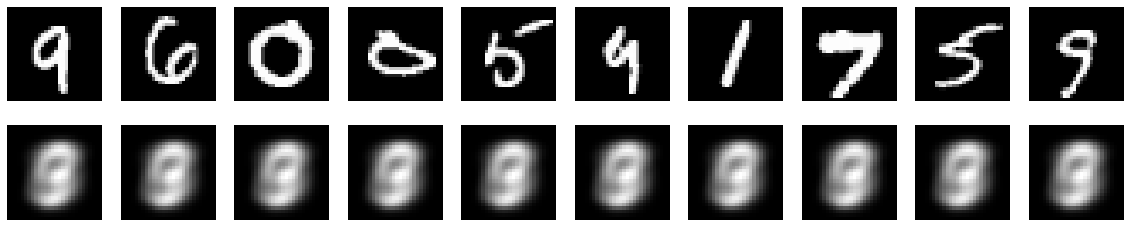

Activation: Sigmoid
Loss: Mean Squared Error
d=2


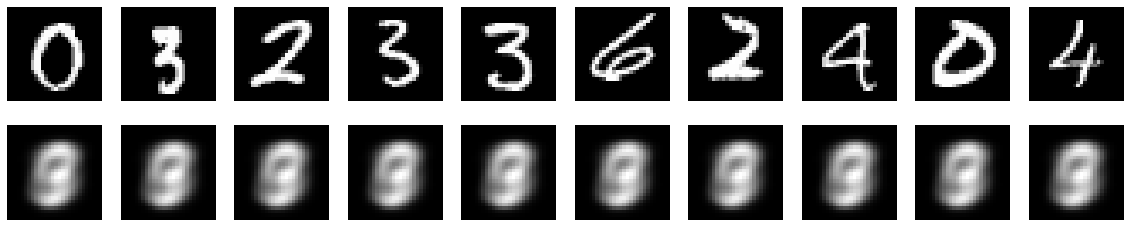

Activation: Relu
Loss: Binary Crossentropy
d=2


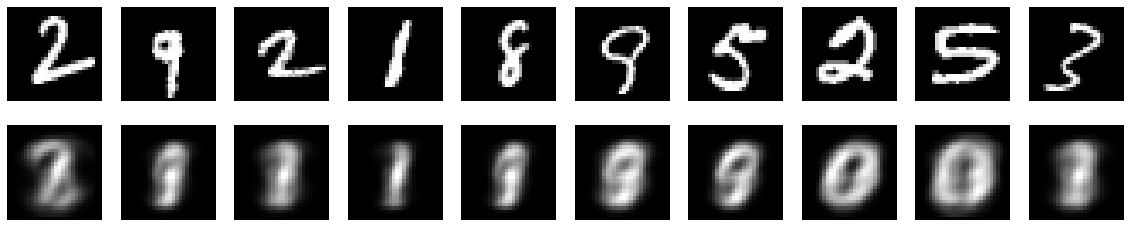

Activation: Relu
Loss: Mean Squared Error
d=2


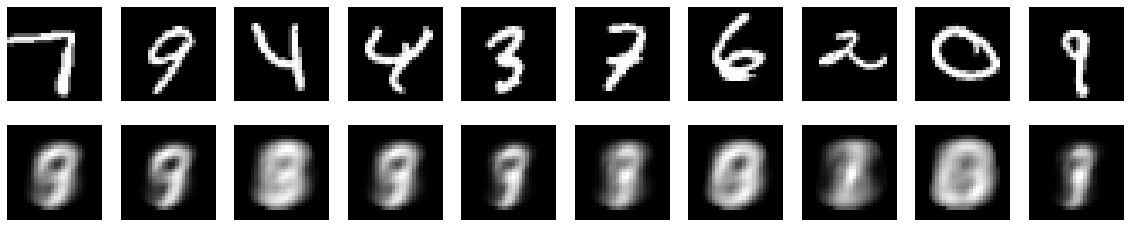

Activation: Sigmoid
Loss: Binary Crossentropy
d=4


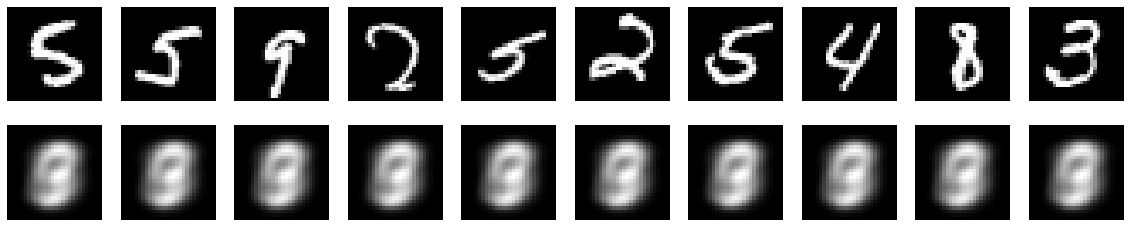

Activation: Sigmoid
Loss: Mean Squared Error
d=4


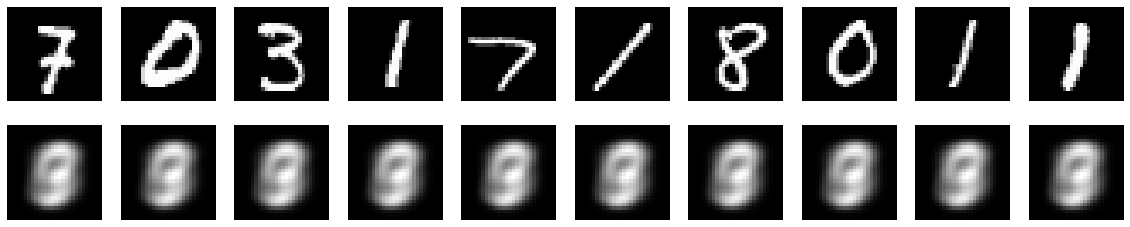

Activation: Relu
Loss: Binary Crossentropy
d=4


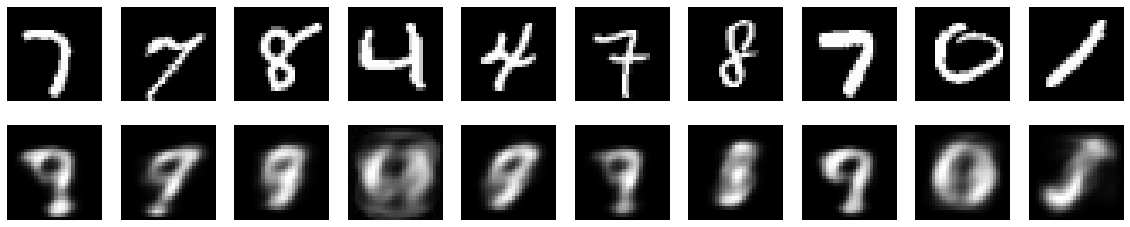

Activation: Relu
Loss: Mean Squared Error
d=4


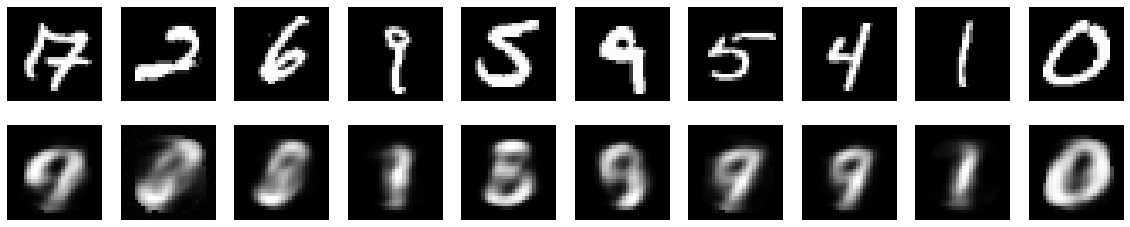

Activation: Sigmoid
Loss: Binary Crossentropy
d=8


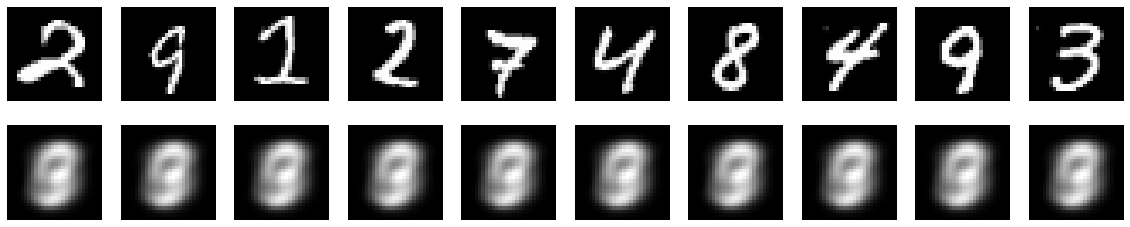

Activation: Sigmoid
Loss: Mean Squared Error
d=8


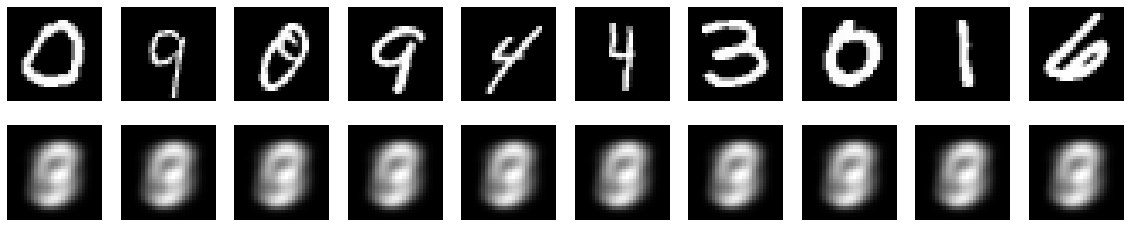

Activation: Relu
Loss: Binary Crossentropy
d=8


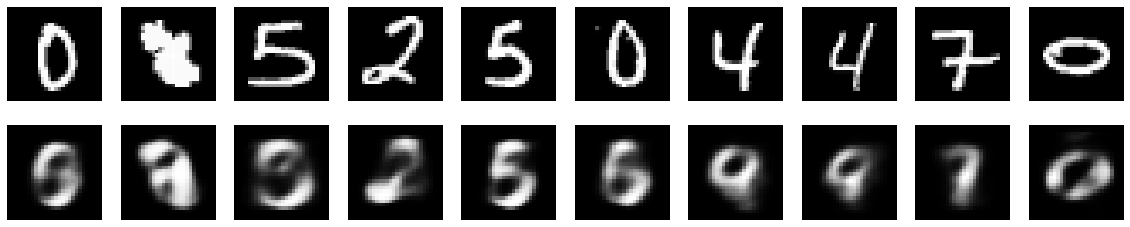

Activation: Relu
Loss: Mean Squared Error
d=8


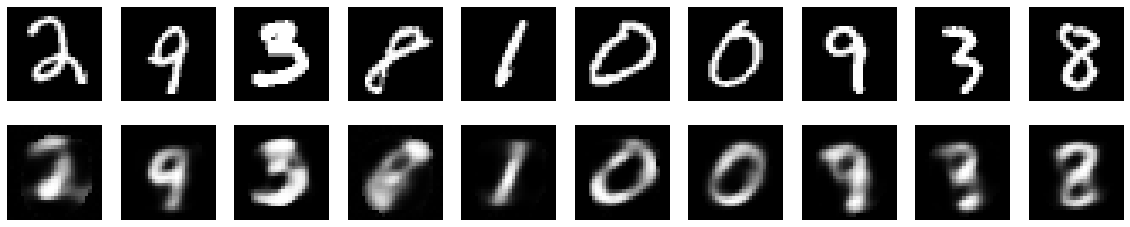

Activation: Sigmoid
Loss: Binary Crossentropy
d=16


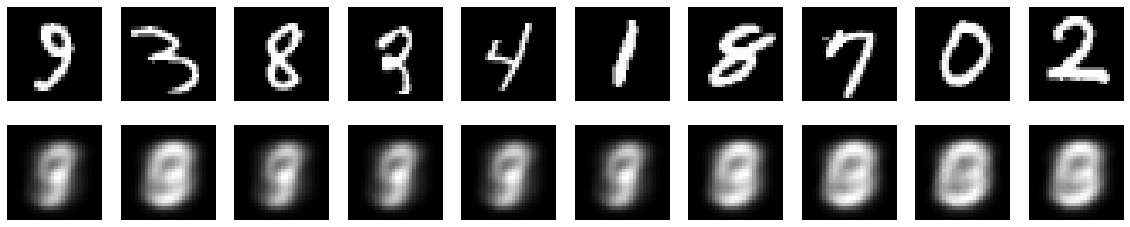

Activation: Sigmoid
Loss: Mean Squared Error
d=16


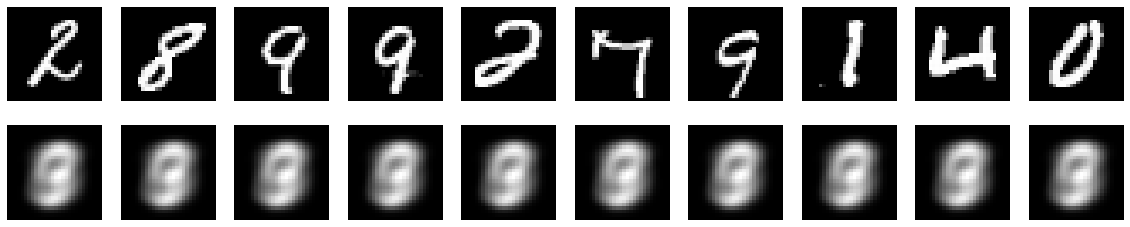

Activation: Relu
Loss: Binary Crossentropy
d=16


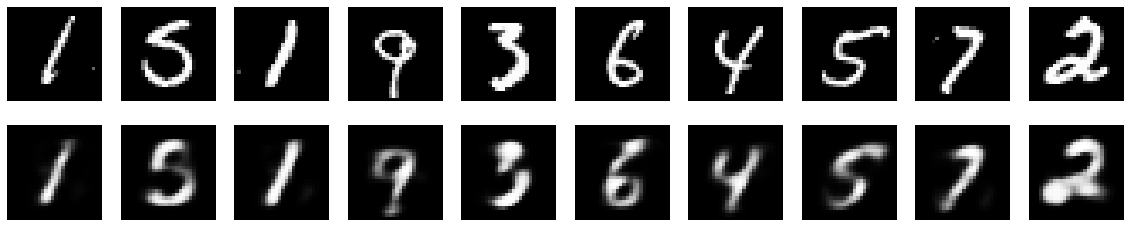

Activation: Relu
Loss: Mean Squared Error
d=16


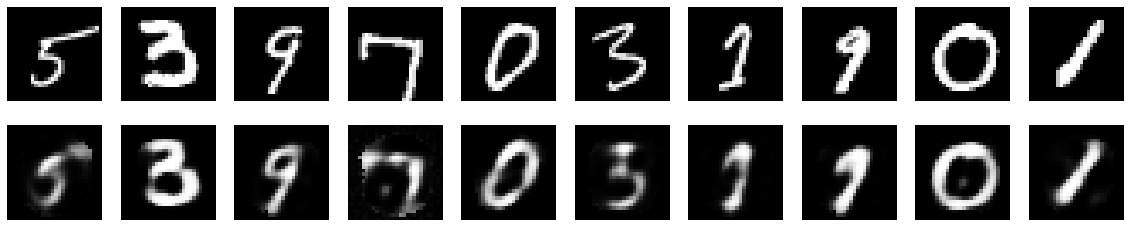

Activation: Sigmoid
Loss: Binary Crossentropy
d=32


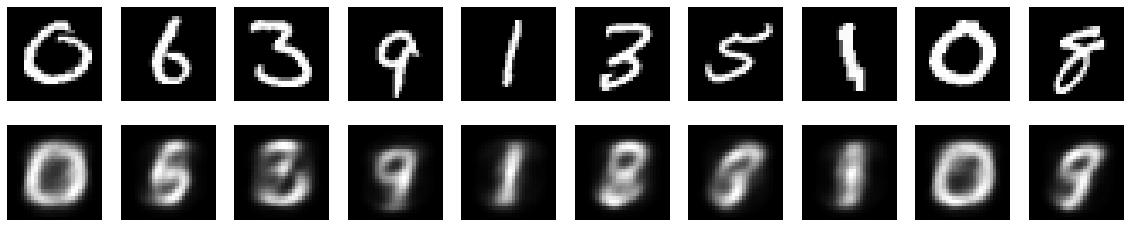

Activation: Sigmoid
Loss: Mean Squared Error
d=32


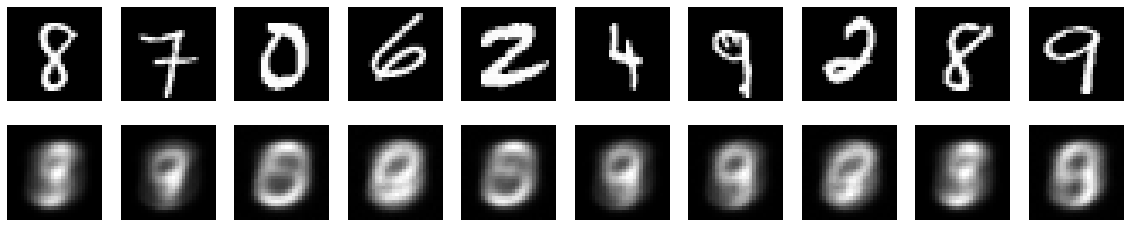

Activation: Relu
Loss: Binary Crossentropy
d=32


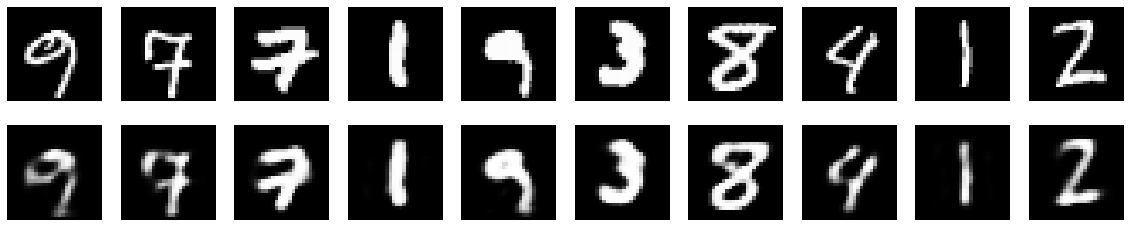

Activation: Relu
Loss: Mean Squared Error
d=32


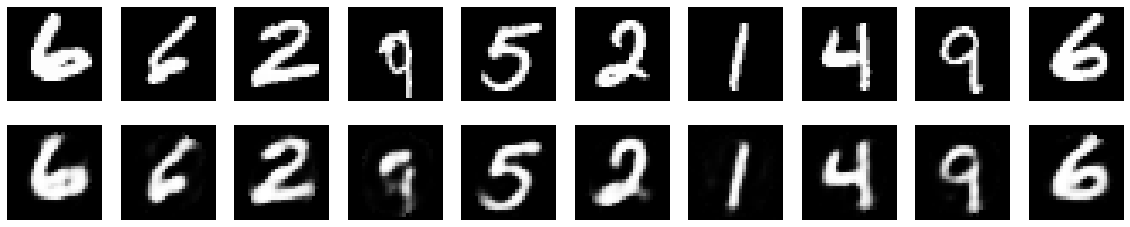

Activation: Sigmoid
Loss: Binary Crossentropy
d=64


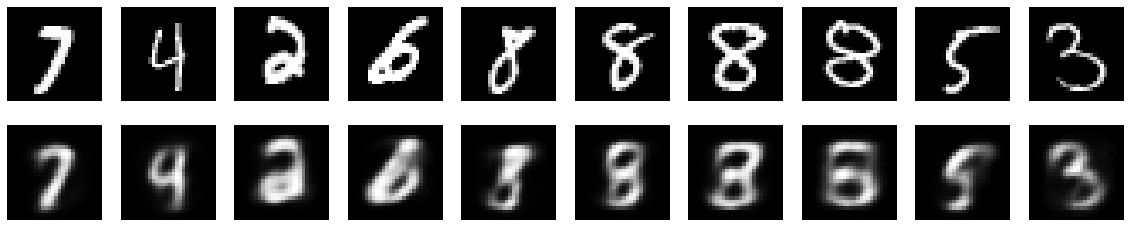

Activation: Sigmoid
Loss: Mean Squared Error
d=64


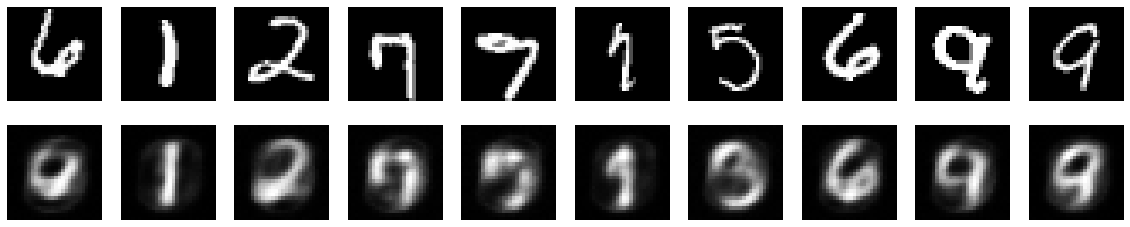

Activation: Relu
Loss: Binary Crossentropy
d=64


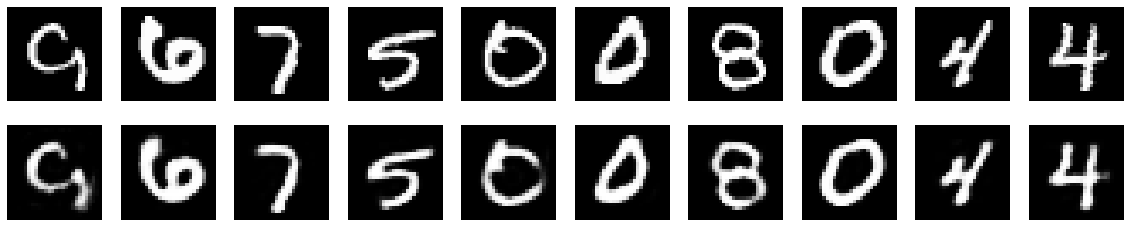

Activation: Relu
Loss: Mean Squared Error
d=64


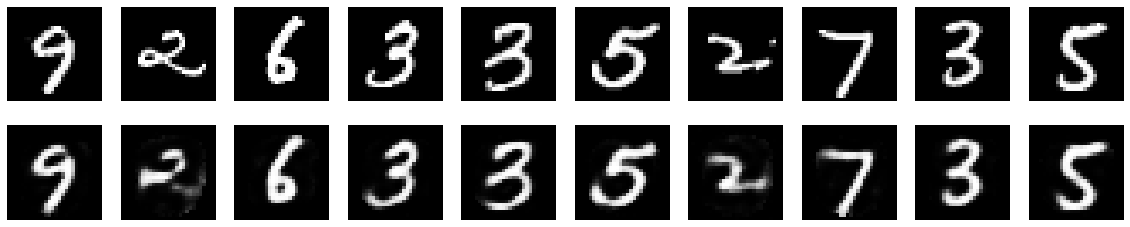

In [0]:
from keras.models import load_model
formato = 'Activation: {0}\nLoss: {1}\nd={2}'
for i in historias:
  if i[-2]=='d':
    d=int(i[-1])
  else:
    d=int(i[-2:])
  act = 'Sigmoid'
  if 'relu' in i:
    act = 'Relu'
  losss = 'Mean Squared Error'
  if '_bc_' in i:
    losss = 'Binary Crossentropy'
  print(formato.format(act,losss,str(d)))
    
  autoencoder = load_model(DATA_PATH+i+'.h5')
  encoder = Model(autoencoder.input, autoencoder.layers[1].output)
  decoder_input = Input(shape=(d,))
  decoder = Model(decoder_input, autoencoder.layers[-1](decoder_input))
  
  encoded_test = encoder.predict(x_test)
  decoded_test = decoder.predict(encoded_test)
  
  import matplotlib.pyplot as plt
  n = 10
  plt.figure(figsize=(20, 4))
  for i in range(n):
      j = np.random.randint(0,len(x_test))
      ax = plt.subplot(2, n, i + 1)
      plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

Se comprueba que entre mas neuronas tenga la capa codificada mejor es la recreación de la imágen, pero para los casos Relu la diferencia entre d=32 y d=64 es baja y no parece compensar el costo computacional.

Se pensó que reducir el sistema a menos de 4 neuronas en la capa codificada, pero se comprueba que usando activación Relu logra reconstruir un número medianamente distinguible, mientras que la activación sigmoidal imprime para todo número un mismo borrón indistinguible, comportandose como se esperaba.

Las primeras redes que logran un resultado gráfico con números correctos cuando d = 8.
Se aprecia que el desempeño de la red que cumple con (act=sigmoid, loss =binary crossentropy, neurons = 64) mejora notablemente con respecto a su versión anterior (neurons=32).


> c) Para verificar la calidad de la representación obtenida, implemente el clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $x$, el clasificador busca las k = 10 imágenes de entrenamiento más similares (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes cercanas. **Mida el error de pruebas** obtenido construyendo este clasificador sobre la data reducida a través del *autoencoder* comparando con la representación reducida obtenida vía PCA (una técnica clásica de reducción de dimensionalidad) utilizando el mismo número de dimensiones $d'$= 2, 4, 8, 16, 32. Considere tanto el error de reconstrucción como el desempeño en clasificación , además de comparar los tiempos medios de predicción en ambos escenarios **¿La representación generada por el *autoencoder* logra generalizar?**

In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

formato = 'Activation: {0}\nLoss: {1}\nd={2}\n'

infile = open(DATA_PATH+'historias_def.p','rb')
historias = pickle.load(infile)
print(historias.keys())

for i in historias:
  print('-------------------------------------------')
  if i[-2]=='d':
    d=int(i[-1])
  else:
    d=int(i[-2:])
  act = 'Sigmoid'
  if 'relu' in i:
    act = 'Relu'
  losss = 'Mean Squared Error'
  if '_bc_' in i:
    losss = 'Binary Crossentropy'
  print(formato.format(act,losss,str(d)))
    
  pca = PCA(n_components=d)
  pca.fit(x_train)
  pca_train = pca.transform(x_train)
  pca_test = pca.transform(x_test)
  
  ...#AUTOENCODER
    
  autoencoder = load_model(DATA_PATH+i+'.h5')
  encoder = Model(autoencoder.input, autoencoder.layers[1].output)
  decoder_input = Input(shape=(d,))
  decoder = Model(decoder_input, autoencoder.layers[-1](decoder_input))
  
  encoded_train = encoder.predict(x_train)
  encoded_test = encoder.predict(x_test)
  
  ...#CLASIFICATION
  clf = KNeighborsClassifier(10)
  clf.fit(pca_train, y_train)
  print('Classification Accuracy PCA %.2f' % clf.score(pca_test,y_test))
  clf = KNeighborsClassifier(10)
  clf.fit(encoded_train, y_train)
  print('Classification Accuracy %.2f' % clf.score(encoded_test,y_test))

-------------------------------------------
Activation: Sigmoid
Loss: Binary Crossentropy
d=2

Classification Accuracy PCA 0.43
Classification Accuracy 0.18
-------------------------------------------
Activation: Sigmoid
Loss: Mean Squared Error
d=2

Classification Accuracy PCA 0.43
Classification Accuracy 0.16
-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=2

Classification Accuracy PCA 0.43
Classification Accuracy 0.32
-------------------------------------------
Activation: Relu
Loss: Mean Squared Error
d=2

Classification Accuracy PCA 0.43
Classification Accuracy 0.33
-------------------------------------------
Activation: Sigmoid
Loss: Binary Crossentropy
d=4

Classification Accuracy PCA 0.63
Classification Accuracy 0.22
-------------------------------------------
Activation: Sigmoid
Loss: Mean Squared Error
d=4

Classification Accuracy PCA 0.63
Classification Accuracy 0.27
-------------------------------------------
Activation: Relu
Loss: 

Se comprueba que la representación del autoencoder silogra generalizar el parendizaje en correlación con el respectivo gráfico de pérdidas. Se nota que el PCA logra resultados mucho mejores cuando d es pequeño (al menos menor que 8). Para los casos finales se aprecia que PCA sigue siendo mejor que que la red, pero en estos casos la diferencia es leve.

 d) Modifique el *autoencoder* básico construido en (a) para implementar un deep autoencoder (*deep AE*), es decir, un autoencoder con al menos dos capas ocultas. **Demuestre experimentalmente** que este *autoencoder* puede mejorar la compresión obtenida por PCA utilizando el mismo número de dimensiones $d'$ . Experimente con $d'$ =2, 4, 8, 16 y distintas profundidades ($L \in [2,4]$). Considere en esta comparación tanto el error de reconstrucción como el desempeño en clasificación (vı́a kNN) de cada representación. Comente.

In [0]:
historias = {}
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
D = [2,4,8,16]
n_epocs=40

for d in D:
  
  pca = PCA(n_components=d)
  pca.fit(x_train)
  
  ############################################################3

  input_img = Input(shape=(784,))

  encoded1 = Dense(1000, activation='relu'  )(input_img)
  encoded2 = Dense(500, activation='relu'   )(encoded1)
  encoded3 = Dense(250, activation='relu'   )(encoded2)
  encoded4 = Dense(d, activation='relu'     )(encoded3)
  decoded4 = Dense(250, activation='relu'   )(encoded4)
  decoded3 = Dense(500, activation='relu'   )(decoded4)
  decoded2 = Dense(1000, activation='relu'  )(decoded3)
  decoded1 = Dense(784, activation='sigmoid')(decoded2)

  autoencoder = Model(input=input_img, output=decoded1)
  encoder = Model(input=input_img, output=encoded3)

  autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
  historias['T3_P2_1_d_relu_prof4_bc_d'+str(d)] = autoencoder.fit(x_train,x_train,epochs=n_epocs,batch_size=32,validation_data=(x_val,x_val))

  autoencoder.save(DATA_PATH+'T3_P2_1_d_relu_prof4_bc_d'+str(d)+'.h5')
  #files.download('T3_P2_1_d_relu_prof4_bc_d'+str(d)+'.h5')

  ############################################################3

  input_img = Input(shape=(784,))

  encoded1 = Dense(1000, activation='relu'  )(input_img)
  encoded2 = Dense(500, activation='relu'   )(encoded1)
  encoded3 = Dense(d, activation='relu'     )(encoded2)
  decoded3 = Dense(500, activation='relu'   )(encoded3)
  decoded2 = Dense(1000, activation='relu'  )(decoded3)
  decoded1 = Dense(784, activation='sigmoid')(decoded2)

  autoencoder = Model(input=input_img, output=decoded1)
  encoder = Model(input=input_img, output=encoded2)

  autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
  historias['T3_P2_1_d_relu_prof3_bc_d'+str(d)] = autoencoder.fit(x_train,x_train,epochs=n_epocs,batch_size=32,validation_data=(x_val,x_val))

  autoencoder.save(DATA_PATH+'T3_P2_1_d_relu_prof3_bc_d'+str(d)+'.h5')
  #files.download('T3_P2_1_d_relu_prof3_bc_d'+str(d)+'.h5')


  ############################################################3

  input_img = Input(shape=(784,))

  encoded1 = Dense(500, activation='relu'   )(input_img)
  encoded2 = Dense(d, activation='relu'     )(encoded1)
  decoded2 = Dense(500, activation='relu'   )(encoded2)
  decoded1 = Dense(784, activation='sigmoid')(decoded2)

  autoencoder = Model(input=input_img, output=decoded1)
  encoder = Model(input=input_img, output=encoded1)

  autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
  historias['T3_P2_1_d_relu_prof2_bc_d'+str(d)] = autoencoder.fit(x_train,x_train,epochs=n_epocs,batch_size=32,validation_data=(x_val,x_val))

  autoencoder.save(DATA_PATH+'T3_P2_1_d_relu_prof2_bc_d'+str(d)+'.h5')
  #files.download('T3_P2_1_d_relu_prof2_bc_d'+str(d)+'.h5')
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 46428 samples, validate on 5001 samples
Epoch 1/40
46428/46428 [==============================] - 23s 500us/step - loss: 0.2642 - val_loss: 0.2484
Epoch 2/40
46428/46428 [==============================] - 15s 317us/step - loss: 0.2315 - val_loss: 0.2294
Epoch 3/40
46428/46428 [==============================] - 15s 314us/step - loss: 0.2201 - val_loss: 0.2183
Epoch 4/40
46428/46428 [==============================] - 15s 314us/step - loss: 0.2119 - val_loss: 0.2095
Epoch 5/40
46428/46428 [==============================] - 15s 315us/step - loss: 0.2057 - val_loss: 0.2058
Epoch 6/40
46428/46428 [==============================] - 15s 316us/step - loss: 0.2006 - val_loss: 0.1993
Epoch 7/40
46428/46428 [==============================] - 15s 314us/step - loss: 0.1965 - val_loss: 0.1951
Epoch 8/40
46428/46428 [==============================] - 15s 314us/step - loss: 0.1927 - val_loss: 0.1932
Epoch 9/40
46428/46428 [==============================] - 15s 313us/step - loss: 0.1899 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 46428 samples, validate on 5001 samples
Epoch 1/40
46428/46428 [==============================] - 22s 471us/step - loss: 0.2702 - val_loss: 0.2513
Epoch 2/40
46428/46428 [==============================] - 13s 290us/step - loss: 0.2339 - val_loss: 0.2327
Epoch 3/40
46428/46428 [==============================] - 13s 289us/step - loss: 0.2238 - val_loss: 0.2247
Epoch 4/40
46428/46428 [==============================] - 13s 289us/step - loss: 0.2174 - val_loss: 0.2188
Epoch 5/40
46428/46428 [==============================] - 13s 288us/step - loss: 0.2133 - val_loss: 0.2150
Epoch 6/40
46428/46428 [==============================] - 13s 289us/step - loss: 0.2094 - val_loss: 0.2096
Epoch 7/40
46428/46428 [==============================] - 13s 289us/step - loss: 0.2058 - val_loss: 0.2074
Epoch 8/40
46428/46428 [==============================] - 13s 288us/step - loss: 0.2029 - val_loss: 0.2039
Epoch 9/40
46428/46428 [==============================] - 13s 290us/step - loss: 0.2005 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 46428 samples, validate on 5001 samples
Epoch 1/40
46428/46428 [==============================] - 19s 402us/step - loss: 0.2594 - val_loss: 0.2398
Epoch 2/40
46428/46428 [==============================] - 10s 217us/step - loss: 0.2316 - val_loss: 0.2342
Epoch 3/40
46428/46428 [==============================] - 10s 217us/step - loss: 0.2271 - val_loss: 0.2303
Epoch 4/40
46428/46428 [==============================] - 10s 217us/step - loss: 0.2234 - val_loss: 0.2263
Epoch 5/40
46428/46428 [==============================] - 10s 218us/step - loss: 0.2204 - val_loss: 0.2243
Epoch 6/40
46428/46428 [==============================] - 10s 220us/step - loss: 0.2183 - val_loss: 0.2213
Epoch 7/40
46428/46428 [==============================] - 10s 218us/step - loss: 0.2167 - val_loss: 0.2200
Epoch 8/40
46428/46428 [==============================] - 10s 218us/step - loss: 0.2153 - val_loss: 0.2194
Epoch 9/40
46428/46428 [==============================] - 10s 220us/step - loss: 0.2141 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 46428 samples, validate on 5001 samples
Epoch 1/40
46428/46428 [==============================] - 23s 503us/step - loss: 0.2626 - val_loss: 0.2404
Epoch 2/40
46428/46428 [==============================] - 15s 317us/step - loss: 0.2191 - val_loss: 0.2072
Epoch 3/40
46428/46428 [==============================] - 15s 316us/step - loss: 0.1955 - val_loss: 0.1839
Epoch 4/40
46428/46428 [==============================] - 15s 316us/step - loss: 0.1776 - val_loss: 0.1736
Epoch 5/40
46428/46428 [==============================] - 15s 317us/step - loss: 0.1699 - val_loss: 0.1707
Epoch 6/40
46428/46428 [==============================] - 15s 315us/step - loss: 0.1655 - val_loss: 0.1656
Epoch 7/40
46428/46428 [==============================] - 15s 315us/step - loss: 0.1621 - val_loss: 0.1603
Epoch 8/40
46428/46428 [==============================] - 15s 316us/step - loss: 0.1594 - val_loss: 0.1568
Epoch 9/40
46428/46428 [==============================] - 15s 316us/step - loss: 0.1571 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 46428 samples, validate on 5001 samples
Epoch 1/40
46428/46428 [==============================] - 22s 480us/step - loss: 0.2500 - val_loss: 0.2201
Epoch 2/40
46428/46428 [==============================] - 14s 291us/step - loss: 0.2098 - val_loss: 0.2065
Epoch 3/40
46428/46428 [==============================] - 14s 292us/step - loss: 0.2009 - val_loss: 0.2009
Epoch 4/40
46428/46428 [==============================] - 14s 292us/step - loss: 0.1933 - val_loss: 0.1861
Epoch 5/40
46428/46428 [==============================] - 14s 291us/step - loss: 0.1797 - val_loss: 0.1744
Epoch 6/40
46428/46428 [==============================] - 14s 291us/step - loss: 0.1711 - val_loss: 0.1672
Epoch 7/40
46428/46428 [==============================] - 13s 291us/step - loss: 0.1666 - val_loss: 0.1636
Epoch 8/40
46428/46428 [==============================] - 14s 291us/step - loss: 0.1634 - val_loss: 0.1604
Epoch 9/40
46428/46428 [==============================] - 13s 291us/step - loss: 0.1609 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 46428 samples, validate on 5001 samples
Epoch 1/40
46428/46428 [==============================] - 19s 410us/step - loss: 0.2554 - val_loss: 0.2093
Epoch 2/40
46428/46428 [==============================] - 10s 221us/step - loss: 0.1984 - val_loss: 0.1945
Epoch 3/40
46428/46428 [==============================] - 10s 221us/step - loss: 0.1890 - val_loss: 0.1883
Epoch 4/40
46428/46428 [==============================] - 10s 219us/step - loss: 0.1837 - val_loss: 0.1824
Epoch 5/40
46428/46428 [==============================] - 10s 219us/step - loss: 0.1797 - val_loss: 0.1788
Epoch 6/40
46428/46428 [==============================] - 10s 219us/step - loss: 0.1767 - val_loss: 0.1763
Epoch 7/40
46428/46428 [==============================] - 10s 220us/step - loss: 0.1743 - val_loss: 0.1740
Epoch 8/40
46428/46428 [==============================] - 10s 220us/step - loss: 0.1724 - val_loss: 0.1733
Epoch 9/40
46428/46428 [==============================] - 10s 221us/step - loss: 0.1708 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 46428 samples, validate on 5001 samples
Epoch 1/40
46428/46428 [==============================] - 24s 509us/step - loss: 0.2657 - val_loss: 0.2383
Epoch 2/40
46428/46428 [==============================] - 15s 319us/step - loss: 0.1946 - val_loss: 0.1794
Epoch 3/40
46428/46428 [==============================] - 15s 318us/step - loss: 0.1672 - val_loss: 0.1631
Epoch 4/40
46428/46428 [==============================] - 15s 319us/step - loss: 0.1579 - val_loss: 0.1513
Epoch 5/40
46428/46428 [==============================] - 15s 317us/step - loss: 0.1486 - val_loss: 0.1412
Epoch 6/40
46428/46428 [==============================] - 15s 318us/step - loss: 0.1405 - val_loss: 0.1347
Epoch 7/40
46428/46428 [==============================] - 15s 318us/step - loss: 0.1360 - val_loss: 0.1328
Epoch 8/40
46428/46428 [==============================] - 15s 318us/step - loss: 0.1328 - val_loss: 0.1298
Epoch 9/40
46428/46428 [==============================] - 15s 317us/step - loss: 0.1304 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 46428 samples, validate on 5001 samples
Epoch 1/40
46428/46428 [==============================] - 23s 490us/step - loss: 0.2398 - val_loss: 0.1885
Epoch 2/40
46428/46428 [==============================] - 14s 294us/step - loss: 0.1731 - val_loss: 0.1587
Epoch 3/40
46428/46428 [==============================] - 14s 294us/step - loss: 0.1509 - val_loss: 0.1426
Epoch 4/40
46428/46428 [==============================] - 14s 295us/step - loss: 0.1404 - val_loss: 0.1363
Epoch 5/40
46428/46428 [==============================] - 14s 293us/step - loss: 0.1350 - val_loss: 0.1307
Epoch 6/40
46428/46428 [==============================] - 14s 293us/step - loss: 0.1313 - val_loss: 0.1279
Epoch 7/40
46428/46428 [==============================] - 14s 292us/step - loss: 0.1284 - val_loss: 0.1251
Epoch 8/40
46428/46428 [==============================] - 14s 294us/step - loss: 0.1261 - val_loss: 0.1243
Epoch 9/40
46428/46428 [==============================] - 14s 295us/step - loss: 0.1243 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 46428 samples, validate on 5001 samples
Epoch 1/40
46428/46428 [==============================] - 19s 416us/step - loss: 0.2366 - val_loss: 0.1824
Epoch 2/40
46428/46428 [==============================] - 10s 221us/step - loss: 0.1699 - val_loss: 0.1589
Epoch 3/40
46428/46428 [==============================] - 10s 220us/step - loss: 0.1543 - val_loss: 0.1504
Epoch 4/40
46428/46428 [==============================] - 10s 221us/step - loss: 0.1471 - val_loss: 0.1430
Epoch 5/40
46428/46428 [==============================] - 10s 221us/step - loss: 0.1428 - val_loss: 0.1408
Epoch 6/40
46428/46428 [==============================] - 10s 220us/step - loss: 0.1398 - val_loss: 0.1370
Epoch 7/40
46428/46428 [==============================] - 10s 219us/step - loss: 0.1374 - val_loss: 0.1345
Epoch 8/40
46428/46428 [==============================] - 10s 221us/step - loss: 0.1355 - val_loss: 0.1329
Epoch 9/40
46428/46428 [==============================] - 10s 222us/step - loss: 0.1338 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 46428 samples, validate on 5001 samples
Epoch 1/40
46428/46428 [==============================] - 24s 520us/step - loss: 0.2472 - val_loss: 0.1939
Epoch 2/40
46428/46428 [==============================] - 15s 321us/step - loss: 0.1670 - val_loss: 0.1473
Epoch 3/40
46428/46428 [==============================] - 15s 321us/step - loss: 0.1426 - val_loss: 0.1374
Epoch 4/40
46428/46428 [==============================] - 15s 320us/step - loss: 0.1308 - val_loss: 0.1229
Epoch 5/40
46428/46428 [==============================] - 15s 319us/step - loss: 0.1225 - val_loss: 0.1165
Epoch 6/40
46428/46428 [==============================] - 15s 321us/step - loss: 0.1161 - val_loss: 0.1124
Epoch 7/40
46428/46428 [==============================] - 15s 321us/step - loss: 0.1120 - val_loss: 0.1100
Epoch 8/40
46428/46428 [==============================] - 15s 321us/step - loss: 0.1091 - val_loss: 0.1093
Epoch 9/40
46428/46428 [==============================] - 15s 321us/step - loss: 0.1067 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 46428 samples, validate on 5001 samples
Epoch 1/40
46428/46428 [==============================] - 23s 497us/step - loss: 0.2197 - val_loss: 0.1632
Epoch 2/40
46428/46428 [==============================] - 14s 295us/step - loss: 0.1481 - val_loss: 0.1352
Epoch 3/40
46428/46428 [==============================] - 14s 295us/step - loss: 0.1309 - val_loss: 0.1232
Epoch 4/40
46428/46428 [==============================] - 14s 295us/step - loss: 0.1221 - val_loss: 0.1165
Epoch 5/40
46428/46428 [==============================] - 14s 293us/step - loss: 0.1168 - val_loss: 0.1118
Epoch 6/40
46428/46428 [==============================] - 14s 295us/step - loss: 0.1130 - val_loss: 0.1089
Epoch 7/40
46428/46428 [==============================] - 14s 296us/step - loss: 0.1101 - val_loss: 0.1096
Epoch 8/40
46428/46428 [==============================] - 14s 295us/step - loss: 0.1078 - val_loss: 0.1050
Epoch 9/40
46428/46428 [==============================] - 14s 295us/step - loss: 0.1058 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 46428 samples, validate on 5001 samples
Epoch 1/40
46428/46428 [==============================] - 20s 421us/step - loss: 0.2241 - val_loss: 0.1643
Epoch 2/40
46428/46428 [==============================] - 10s 221us/step - loss: 0.1498 - val_loss: 0.1358
Epoch 3/40
46428/46428 [==============================] - 10s 221us/step - loss: 0.1336 - val_loss: 0.1278
Epoch 4/40
46428/46428 [==============================] - 10s 222us/step - loss: 0.1258 - val_loss: 0.1209
Epoch 5/40
46428/46428 [==============================] - 10s 222us/step - loss: 0.1208 - val_loss: 0.1163
Epoch 6/40
46428/46428 [==============================] - 10s 222us/step - loss: 0.1174 - val_loss: 0.1135
Epoch 7/40
46428/46428 [==============================] - 10s 222us/step - loss: 0.1147 - val_loss: 0.1112
Epoch 8/40
46428/46428 [==============================] - 10s 223us/step - loss: 0.1124 - val_loss: 0.1093
Epoch 9/40
46428/46428 [==============================] - 10s 222us/step - loss: 0.1103 - val_l

In [0]:
pickle.dump(historias,open(DATA_PATH+'historias_deep_def.p','wb'))

In [0]:
modelos_deep = ['T3_P2_1_d_relu_prof2_bc_d2','T3_P2_1_d_relu_prof2_bc_d4','T3_P2_1_d_relu_prof2_bc_d8','T3_P2_1_d_relu_prof2_bc_d16',
                'T3_P2_1_d_relu_prof3_bc_d2','T3_P2_1_d_relu_prof3_bc_d4','T3_P2_1_d_relu_prof3_bc_d8','T3_P2_1_d_relu_prof3_bc_d16',
                'T3_P2_1_d_relu_prof4_bc_d2','T3_P2_1_d_relu_prof4_bc_d4','T3_P2_1_d_relu_prof4_bc_d8','T3_P2_1_d_relu_prof4_bc_d16',
               ]

for i in modelos_deep:
  print(i)
  mod = load_model(DATA_PATH+i+'.h5')
  mod.summary()

T3_P2_1_d_relu_prof2_bc_d2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_87 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_64 (Dense)             (None, 2)                 1002      
_________________________________________________________________
dense_65 (Dense)             (None, 500)               1500      
_________________________________________________________________
dense_66 (Dense)             (None, 784)               392784    
Total params: 787,786
Trainable params: 787,786
Non-trainable params: 0
_________________________________________________________________
T3_P2_1_d_relu_prof2_bc_d4
_________________________________________________________________
Layer (type)    

In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

modelos_deep = ['T3_P2_1_d_relu_prof2_bc_d2',
                'T3_P2_1_d_relu_prof2_bc_d4',
                'T3_P2_1_d_relu_prof2_bc_d8',
                'T3_P2_1_d_relu_prof2_bc_d16',
                'T3_P2_1_d_relu_prof3_bc_d2',
                'T3_P2_1_d_relu_prof3_bc_d4',
                'T3_P2_1_d_relu_prof3_bc_d8',
                'T3_P2_1_d_relu_prof3_bc_d16',
                'T3_P2_1_d_relu_prof4_bc_d2',
                'T3_P2_1_d_relu_prof4_bc_d4',
                'T3_P2_1_d_relu_prof4_bc_d8',
                'T3_P2_1_d_relu_prof4_bc_d16'
               ]

predicciones=[]

formato = 'Activation: {0}\nLoss: {1}\nd={2}\nDeepth: {3}'

for i in range(len(modelos_deep)):
  print('-------------------------------------------')
  if modelos_deep[i][-2]=='d':
    d=int(modelos_deep[i][-1])
  else:
    d=int(modelos_deep[i][-2:])
  act = 'Sigmoid'
  if 'relu' in modelos_deep[i]:
    act = 'Relu'
  losss = 'Mean Squared Error'
  if '_bc_' in modelos_deep[i]:
    losss = 'Binary Crossentropy'
  prof = int(modelos_deep[i][19])
  print(formato.format(act,losss,str(d),str(prof)))
  
  pca = PCA(n_components=d)
  pca.fit(x_train)
  pca_train = pca.transform(x_train)
  pca_test = pca.transform(x_test)
  
  ...#AUTOENCODER
  autoencoder = load_model(DATA_PATH+modelos_deep[i]+'.h5')
  encoder = Model(input=autoencoder.input, output=autoencoder.layers[prof].output)
  #decoder_input = Input(shape=(d,))
  #decoder = Model(input=autoencoder.layers[prof].input, output=autoencoder.outut)
  
  encoded_train = autoencoder.predict(x_train)
  encoded_test = autoencoder.predict(x_test)
  
  ...#CLASIFICATION
  clf = KNeighborsClassifier(10)
  clf.fit(pca_train, y_train)
  print('Classification Accuracy PCA %.2f' % clf.score(pca_test,y_test))
  clf = KNeighborsClassifier(10)
  clf.fit(encoded_train, y_train)
  print('Classification Accuracy %.2f' % clf.score(encoded_test,y_test))     

-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=2
Deepth: 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Classification Accuracy PCA 0.43
Classification Accuracy 0.59
-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=4
Deepth: 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Classification Accuracy PCA 0.63
Classification Accuracy 0.85
-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=8
Deepth: 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Classification Accuracy PCA 0.90
Classification Accuracy 0.93
-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=16
Deepth: 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Classification Accuracy PCA 0.96
Classification Accuracy 0.96
-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=2
Deepth: 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Classification Accuracy PCA 0.43
Classification Accuracy 0.75
-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=4
Deepth: 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Classification Accuracy PCA 0.63
Classification Accuracy 0.90
-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=8
Deepth: 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Classification Accuracy PCA 0.90
Classification Accuracy 0.95
-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=16
Deepth: 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Classification Accuracy PCA 0.96
Classification Accuracy 0.96
-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=2
Deepth: 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Classification Accuracy PCA 0.43
Classification Accuracy 0.76
-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=4
Deepth: 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Classification Accuracy PCA 0.63
Classification Accuracy 0.90
-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=8
Deepth: 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Classification Accuracy PCA 0.90


Este item generó timeOut, se repite el experimento con la información faltante.

In [0]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

modelos_deep = [
                'T3_P2_1_d_relu_prof2_bc_d8',
                'T3_P2_1_d_relu_prof4_bc_d8',
                'T3_P2_1_d_relu_prof4_bc_d16'
               ]

predicciones=[]

formato = 'Activation: {0}\nLoss: {1}\nd={2}\nDeepth: {3}'

for i in range(len(modelos_deep)):
  print('-------------------------------------------')
  if modelos_deep[i][-2]=='d':
    d=int(modelos_deep[i][-1])
  else:
    d=int(modelos_deep[i][-2:])
  act = 'Sigmoid'
  if 'relu' in modelos_deep[i]:
    act = 'Relu'
  losss = 'Mean Squared Error'
  if '_bc_' in modelos_deep[i]:
    losss = 'Binary Crossentropy'
  prof = int(modelos_deep[i][19])
  print(formato.format(act,losss,str(d),str(prof)))
  
  pca = PCA(n_components=d)
  pca.fit(x_train)
  pca_train = pca.transform(x_train)
  pca_test = pca.transform(x_test)
  
  ...#AUTOENCODER
  autoencoder = load_model(DATA_PATH+modelos_deep[i]+'.h5')
  encoder = Model(input=autoencoder.input, output=autoencoder.layers[prof].output)
  #decoder_input = Input(shape=(d,))
  #decoder = Model(input=autoencoder.layers[prof].input, output=autoencoder.outut)
  
  encoded_train = autoencoder.predict(x_train)
  encoded_test = autoencoder.predict(x_test)
  
  ...#CLASIFICATION
  clf = KNeighborsClassifier(10)
  clf.fit(pca_train, y_train)
  print('Classification Accuracy PCA %.2f' % clf.score(pca_test,y_test))
  clf = KNeighborsClassifier(10)
  clf.fit(encoded_train, y_train)
  print('Classification Accuracy %.2f' % clf.score(encoded_test,y_test))     

-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=8
Deepth: 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Classification Accuracy PCA 0.90
Classification Accuracy 0.95
-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=16
Deepth: 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Classification Accuracy PCA 0.96


Nuevamente se imprime la estructura de cada red en modo de comprobación. Se aprecia que todas fueron creadas correctamente.
Se aprecia que el resultado de la red mejora con respecto al PCA. Se aprecia tamién que añadir capas permite una mayor presición de la reconstrucción del resultado para una capa codificada pequeña, permitiendo mejorar en más de un  20% el peor caso del ejercicio anterior. 


> e) Elija algunas de las representaciones aprendidas anteriormente ($d>2$) y visualı́celas usando la herramienta *TSNE* disponible en la librerı́a *sklearn*. **Compare cualitativamente el resultado con aquel obtenido usando PCA** con el mismo número de componentes ($d>2$). Finalmente **grafique una representación** generada por un autoencoder directamente ($d=2$), comente.

-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=2
Deepth: 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=8
Deepth: 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


-------------------------------------------
Activation: Relu
Loss: Binary Crossentropy
d=16
Deepth: 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


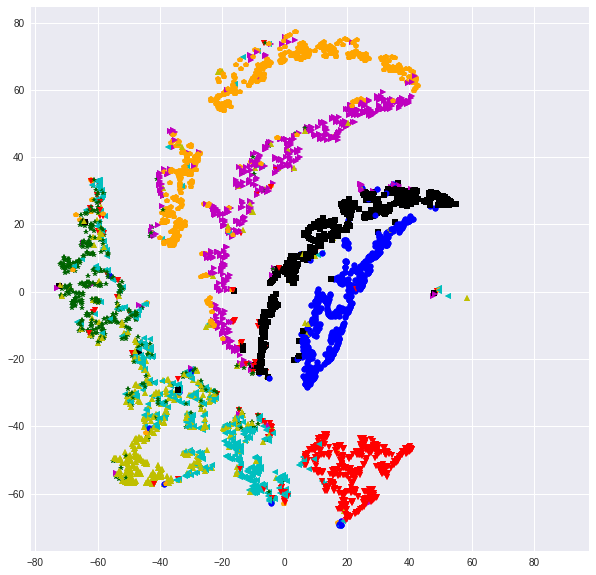

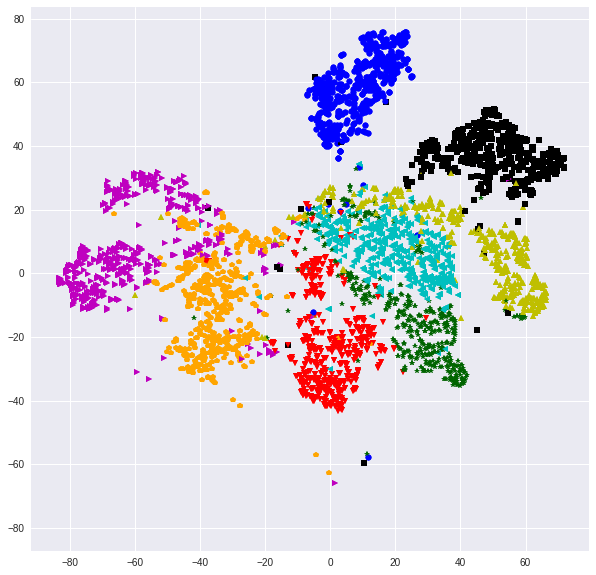

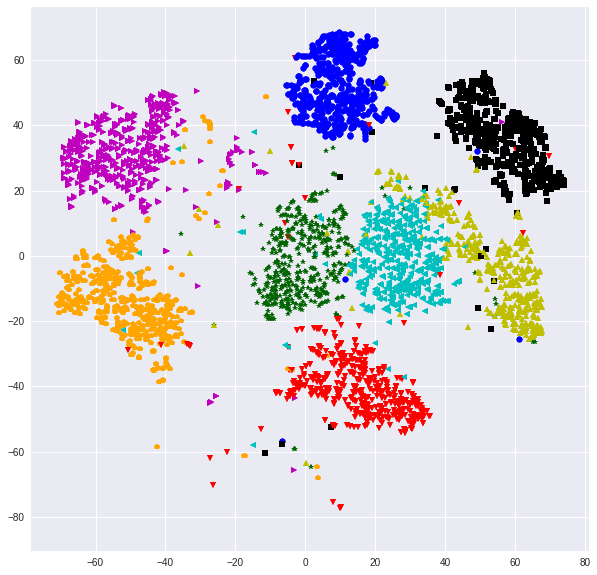

In [17]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

mods= ['T3_P2_1_d_relu_prof3_bc_d2',
       'T3_P2_1_d_relu_prof4_bc_d8',
       'T3_P2_1_d_relu_prof4_bc_d16'
      ]

formato = 'Activation: {0}\nLoss: {1}\nd={2}\nDeepth: {3}'

for i in range(len(mods)):

  print('-------------------------------------------')
  if modelos_deep[i][-2]=='d':
    d=int(modelos_deep[i][-1])
  else:
    d=int(modelos_deep[i][-2:])
  act = 'Sigmoid'
  if 'relu' in modelos_deep[i]:
    act = 'Relu'
  losss = 'Mean Squared Error'
  if '_bc_' in modelos_deep[i]:
    losss = 'Binary Crossentropy'
  prof = int(modelos_deep[i][19])
  print(formato.format(act,losss,str(d),str(prof)))
  
  autoencoder = load_model(DATA_PATH+mods[i]+'.h5')
  encoder = Model(input=autoencoder.input, output=autoencoder.layers[prof].output)
  
  nplot=5000 #warning: mind your memory!

  encoded_train = encoder.predict(x_train[:nplot])
  from sklearn.manifold import TSNE

  model = TSNE(n_components=2, random_state=0)
  encoded_train = model.fit_transform(encoded_train)

  plt.figure(figsize=(10, 10))
  colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
  markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}

  for idx in range(0,nplot):
      label = y_train[idx]
      line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
          color=colors[label], marker=markers[label], markersize=6)
  pca = PCA(n_components=d)
  pca.fit(x_train)
  pca_train = pca.transform(x_train)
  pca_test = pca.transform(x_test)
  ... #plot PCA

  for idx in range(0,nplot):
      label = y_train[idx]
      line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
          color=colors[label], marker=markers[label], markersize=6)

Se procede  a analizar con dos redes en lugar de una. La que obtuvo mejor y la que obtuvo peor resultado en el ítem anterior. Finalmente una con depth = 2.

Se aprecia en el primer caso que la representación de los números está revueltos, lo que se hace evidente para los datos verdes y celestes en el gráfico. También se ve sobreposicionamiento en las figuras negras sobre las azules. En el segundo caso las variables están mas cerca entre sí, pero menos revueltas, lo que explica el buen resultado obtenido.

El ultimo caso también tiene los datos separados y en este caso con una mayor distancia, por lo que se esperaría un mejor resultado de no tener la información de la cantidad de capas de profundidad  de la red. Esto termina por comprobar la capacidad de la profundización de la red para mejorar el resultado obtenido.

f) Cuando el problema se torna más difícil es necesario complejizar el modelo. Modifique el autoencoder construido en (a) para trabajar directamente sobre las imágenes de MNIST, sin tratarlas como vectores de 784 atributos, sino como matrices de tamaño $1\times28\times28$. Es posible lograr este objetivo utilizando capas convolucionales para definir el *Encoder* y capas con **convoluciones transpuesta** en el *Decoder*, comente como sufre las transformaciones el patrón de entrada. Compare la calidad de la representación reducida obtenida por el nuevo autoencoder con aquella obtenida anteriormente utilizando el mismo número de dimensiones. Comente.

In [17]:
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) #modify for th dim ordering
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
from keras.layers import *
input_img = Input(shape=(28, 28, 1))
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 7, 7, 16)          2320      
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 16)        0         
__________

In [19]:
convol=autoencoder.compile(optimizer='adam', loss='mean_squared_error')
convolhist = autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

Train on 37142 samples, validate on 9286 samples
Epoch 1/50
37142/37142 [==============================] - 3s 82us/step - loss: 0.1127 - val_loss: 0.1101
Epoch 2/50
37142/37142 [==============================] - 2s 67us/step - loss: 0.1127 - val_loss: 0.1101
Epoch 3/50
37142/37142 [==============================] - 2s 65us/step - loss: 0.1127 - val_loss: 0.1101
Epoch 4/50
37142/37142 [==============================] - 2s 64us/step - loss: 0.1127 - val_loss: 0.1101
Epoch 5/50
37142/37142 [==============================] - 2s 65us/step - loss: 0.1127 - val_loss: 0.1101
Epoch 6/50
37142/37142 [==============================] - 2s 65us/step - loss: 0.1127 - val_loss: 0.1101
Epoch 7/50
37142/37142 [==============================] - 2s 64us/step - loss: 0.1127 - val_loss: 0.1101
Epoch 8/50
37142/37142 [==============================] - 2s 64us/step - loss: 0.1127 - val_loss: 0.1101
Epoch 9/50
37142/37142 [==============================] - 2s 64us/step - loss: 0.1127 - val_loss: 0.1101
Epoch 

In [20]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

mods = [convol]
prof =1
d=64

formato = 'Activation: {0}\nLoss: {1}\nd={2}\nDeepth: {3}'

for i in range(len(mods)):

  print('-------------------------------------------')
  

  encoder = Model(input=autoencoder, output=autoencoder.layers[prof].output)
  
  nplot=5000 #warning: mind your memory!

  encoded_train = encoder.predict(x_train[:nplot])
  from sklearn.manifold import TSNE

  model = TSNE(n_components=2, random_state=0)
  encoded_train = model.fit_transform(encoded_train)

  plt.figure(figsize=(10, 10))
  colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
  markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}

  for idx in range(0,nplot):
      label = y_train[idx]
      line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
          color=colors[label], marker=markers[label], markersize=6)
  pca = PCA(n_components=d)
  pca.fit(x_train)
  pca_train = pca.transform(x_train)
  pca_test = pca.transform(x_test)

  for idx in range(0,nplot):
      label = y_train[idx]
      line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
          color=colors[label], marker=markers[label], markersize=6)

-------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=<keras.eng..., outputs=Tensor("co...)`
  from ipykernel import kernelapp as app


ValueError: ignored

<a id="refs"></a>
## Referencias
[1] George Kingsley Zipf (1949), *Human behavior and the principle of least effort*, Addison-Wesley Press  
[2] https://www.nvidia.es/object/cuda-parallel-computing-es.html  
[3] http://yann.lecun.com/exdb/mnist/  
[4] Vincent, P., Larochelle, H., Bengio, Y., & Manzagol, P. A. (2008, July). *Extracting and composing robust features with denoising autoencoders*. ACM.